In [145]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
import math
import collections
from pm4py.algo.evaluation.earth_mover_distance import algorithm as earth_mover_distance

In [146]:
file_name = "syn_3"
attribute_key = "property_lt_20"

In [147]:
case_attribute_key = f'case:{attribute_key}'
case_id_key = "case:concept:name"

# df = pm4py.read_xes(f'../logs/{file_name}.xes')
df = pd.read_csv(f'../logs/{file_name}.{attribute_key}.csv')
df["time:timestamp"] = pd.to_datetime(df['time:timestamp'])
df["case:concept:name"] = df['case:concept:name'].astype(str)
df["concept:name"] = df['concept:name'].astype(str)

df = df.dropna(subset=[case_attribute_key]).reset_index() # filter empty rows

In [148]:
def uEMSC(l, m):
    return 1 - sum([ max(pr - (m.get(tr) or 0), 0) for tr, pr in l.items() if pr > 0 ])

In [149]:
def cuEMSC(l1, l2, s1, s2, phi=10):
    sl1 = { k: v / s1 for k, v in l1.items() }
    sl2 = { k: v / s2 for k, v in l2.items() }

    d = uEMSC(sl1, sl2)

    full = sum([ [k] * v for k, v in l1.items() ] + [ [k] * v for k, v in l2.items() ], [])

    s = 0
    for i in range(phi):

        rs1 = [ full[math.floor(len(full) * r)] for r in np.random.random_sample((int(s1),)) ]

        l1_ = collections.Counter(rs1)
        l2_ = collections.Counter(full) - l1_

        sl1_ = { k: v / s1 for k, v in l1_.items() }
        sl2_ = { k: v / s2 for k, v in l2_.items() }

        d_ = uEMSC(sl1_, sl2_)

        s = s + d_

    return d / (s / phi)


In [150]:
cuEMSC({"a":4, "ab":2}, {"a":3, "b":4}, 6, 7)

0.6474820143884892

In [151]:
attribute_values = pm4py.get_trace_attribute_values(df, attribute_key)
sorted_attribute_values = sorted([ float(k) for k in attribute_values.keys() ])

# group df by case ids
grouped = df.filter([case_id_key, case_attribute_key]).groupby(case_id_key, sort=False)

In [152]:
df_gte_light = grouped.first() # initial gte group

# define absolute languages (counting the occurrence of cases)
# devide absoulte numbers by total number of cases later(!), otherwise every values has to be updated
language_lt = {}
language_gte = pm4py.stats.get_variants(df)

uemscs = []

t = time.time()

for pivot in sorted_attribute_values[1:]:

    # find affected cases
    df_affected_light_idx = df_gte_light[df_gte_light[case_attribute_key] < pivot].index

    # remove affected cases from gte group
    df_gte_light.drop(df_affected_light_idx, inplace=True)

    # translate into full df
    df_affected = pd.concat([ df.loc[grouped.indices[i]] for i in df_affected_light_idx ])

    # update absoulte languages
    for tr, n in pm4py.stats.get_variants(df_affected).items():
        language_lt[tr] = language_lt.setdefault(tr, 0) + n
        language_gte[tr] = language_gte[tr] - n

    language_lt_size = sum(language_lt.values(), 0.0)
    language_gte_size = sum(language_gte.values(), 0.0)

    # stochastic_language_lt = { k: v / language_lt_size for k, v in language_lt.items() }
    # stochastic_language_gte = { k: v / language_gte_size for k, v in language_gte.items() }

    uemsc = cuEMSC(language_lt, language_gte, language_lt_size, language_gte_size)

    # collect data to plot graph
    uemscs.append(uemsc)

t = time.time() - t

time.sleep(1)

print(f"time elapsed: {t}")

time elapsed: 5.9445390701293945


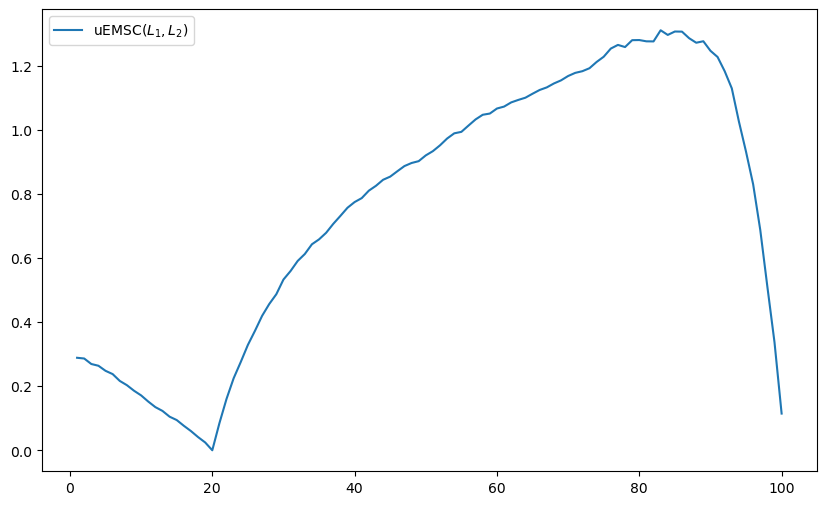

In [153]:
plt.figure(figsize=(10,6))

# plot mmlngld
plt.plot(sorted_attribute_values[1:], uemscs, label=r"uEMSC$(L_1,L_2)$")
plt.legend()
plt.savefig(f"out.cuemsc.{file_name}.{attribute_key}.png", bbox_inches="tight")

In [154]:
pd.DataFrame({"cuemsc": uemscs}).to_csv(f"out.cuemsc.{file_name}.{attribute_key}.csv", index=False, header=False)